# Imports

In [518]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import collections
import networkx as nx
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pdb

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

os.chdir("/home/jacobheglund/dev/raildelay")
print(os.getcwd())

/home/jacobheglund/dev/raildelay


In [2]:
# include all these data points
# Path(log_dir).mkdir(parents=True, exist_ok=True)
# Path(ckpt_dir).mkdir(parents=True, exist_ok=True)
dataset_name = "raildelays"
raw_dir = "./data/raw/" + dataset_name + "/"
interim_dir = "./data/interim/" + dataset_name + "/"
processed_dir = "./data/processed/" + dataset_name + "/"

Path(raw_dir).mkdir(parents=True, exist_ok=True)
Path(interim_dir).mkdir(parents=True, exist_ok=True)
Path(processed_dir).mkdir(parents=True, exist_ok=True)

#TODO have a standard way of naming these things for the model (#code_goals)
## ex: adj_path = processed_dir + "adj.npy"
## ex: dataset_path = processed_dir + "dataset.npy"

raw_data_path_2016 = raw_dir + "HSP_2016_DID_PAD.txt"
raw_data_path_2017 = raw_dir + "HSP_2017_DID_PAD.txt"
stop_position_path = raw_dir + "stations.csv"
adjlist_path = interim_dir + "adjlist.txt"
adj_path = processed_dir + "adj.npy"
dataset_path = processed_dir + "dataset.npy"



# Link-Based Node Formulation


## Data Preprocssing

In [3]:
df1 = pd.read_csv(raw_data_path_2016, sep=",")
df2 = pd.read_csv(raw_data_path_2017, sep=",")
df2 = df2.drop(["Unnamed: 0"], axis=1)
df = pd.concat([df1, df2])

# 2017 includes XXXPAD and PADXXX trips, 2016 does not, so remove the outbound trips
df = df[df["station_origin"] != "PAD"]

# remove any stops that are included in either year but not the other
stops_2016 = np.unique(df1["station_curr"])
stops_2017 = np.unique(df2["station_curr"])
stops_drop = []

for i in stops_2017:
    if i not in stops_2016:
        stops_drop.append(i)
for i in stops_2016:
    if i not in stops_2017:
        stops_drop.append(i)
for i in stops_drop:
    df = df[df["station_curr"] != i]
    

# remove stations that serve an average of less than stop_thres trains per day 
stations = np.unique(df["station_curr"])
n_days = len(np.unique(df["date"]))
# stops per station
sps = dict(collections.Counter(df["station_curr"]))
sps = dict(sorted(sps.items()))

# if you change this value you will have to manually change the corridors and available routes since
# that process is difficult to automate at this point in time
stop_thres = 1
counter = 0
for i in list(sps):
    if (sps[i] / n_days) < stop_thres:
        # find set of RID's associated with these
        df_tmp = df.loc[df["station_curr"] == i]
        RID_drop = np.unique(df_tmp["RID"])
        # remove train routes that stop at any of the non-included stations
        for j in RID_drop:
            df = df.loc[df["RID"] != j]
        sps.pop(i)

df = df.reset_index()
df = df.drop(["index"], axis=1)


In [4]:
stops_data_period = np.unique(df["station_curr"])
df_sp = pd.read_csv(stop_position_path)
stop_position = {}
for i in range(len(df_sp)):
    curr_row = df_sp[i:i+1]
    if curr_row["crs"].item() in stops_data_period:
        stop_position[curr_row["crs"].item()] = (curr_row["lat"].item(), curr_row["lon"].item())



In [5]:
# all corridors are defined in linear order
## once a train gets on a corridor, it travels through all the stations on that corridor
## although it does not necessarily stop at any of the stations on that corridor

# the corridors are designed with the threshold of at least 1 train per day on average
## it keeps out the "end of line" stations which just add noise to the data
## in total this removes ~1% of the data

# list of railway stations
## https://en.wikipedia.org/wiki/UK_railway_stations_%E2%80%93_A

# station map for defining corridors
## https://www.gwr.com/plan-journey/stations-and-routes 


# --------------------------------------------
# Northwest Corridor
# --------------------------------------------
# SWA - SWANSEA - START OF CORRIDOR
# NTH - NEATH
# PTA - PORT TALBOT PARKWAY
# BGN - BRIDGEND
# CDF - CARDIFF CENTRAL
# NWP - NEWPORT
# BPW - BRISTOL PARKWAY
# SWI - SWINDON - END OF CORRIDOR

# --------------------------------------------
# Southwest Corridor
# --------------------------------------------
# WSM - WESTON-SUPER-MARE - START OF CORRIDOR
# WNM - WESTON MILTON
# WOR - WORLE
# YAT - YATTON
# NLS - NAILSEA AND BLACKWELL
# BRI - BRISTON TEMPLE MEADS
# BTH - BATH SPA
# CPM - CHIPPENHAM
# SWI - SWINDON - END OF CORRIDOR

# --------------------------------------------
# Middle Connecting Corridor
# --------------------------------------------
# SWI - SWINDON - START OF CORRIDOR
# DID - DIDCOT PARKWAY - END OF CORRIDOR

# --------------------------------------------
# North Central Corridor
# --------------------------------------------
# BAN - BANBURY - START OF CORRIDOR
# KGS - KINGS SUTTON
# HYD - HEYFORD
# TAC - TACKLEY
# OXF - OXFORD
# RAD - RADLEY
# CUM - CULHAM
# APF - APPLEFORD
# DID - DIDCOT PARKWAY - END OF CORRIDOR

# --------------------------------------------
# Eastern Corridor
# --------------------------------------------
# DID - DIDCOT PARKWAY - START OF CORRIDOR
# CHO - CHOLSEY
# GOR - GORING AND STREATLEY
# PAN - PANGBOURNE
# TLH - TILEHURST
# RDG - READING
# TWY - TWYFORD
# MAI - MAIDENHEAD
# BNM - BURNHAM
# SLO - SLOUGH
# LNY - LANGLEY
# IVR - IVER
# WDT - WEST DRAYTON
# HAY - HAYES AND HARLINGTON
# STL - SOUTHALL
# EAL - EALING BROADWAY
# PAD - LONDON PADDINGTON - END OF CORRIDOR

# used in defining the graph
corridor_list = [
    ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI"],
    ["WSM", "WNM", "WOR", "YAT", "NLS", "BRI", "BTH", "CPM", "SWI"],
    ["SWI", "DID"],
    ["BAN", "KGS", "HYD", "TAC", "OXF", "RAD", "CUM", "APF", "DID"],
    ["DID", "CHO", "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"]
]

# rearrange sps with stops grouped by corridor
sps_tmp = {}
for corridor in corridor_list:
    for j in corridor:
        keys = list(sps_tmp)
        if j not in keys:
            sps_tmp[j] = sps[j]
sps = sps_tmp

# used in finding links between stops
available_routes = [
    ["SWA", "NTH", "PTA", "BGN", "CDF", "NWP", "BPW", "SWI", "DID", "CHO",
     "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"],
    
    ["WSM", "WNM", "WOR", "YAT", "NLS", "BRI", "BTH", 
     "CPM", "SWI", "DID", "CHO", "GOR", "PAN", "TLH", "RDG", "TWY", "MAI",
     "BNM", "SLO", "LNY", "IVR", "WDT", "HAY", "STL", "EAL", "PAD"],
    
    ["BAN", "KGS", "HYD", "TAC", "OXF", "RAD", "CUM", "APF", "DID", "CHO",
     "GOR", "PAN", "TLH", "RDG", "TWY", "MAI", "BNM", "SLO", "LNY",
     "IVR", "WDT", "HAY", "STL", "EAL", "PAD"]
]

In [6]:
def get_links(stop_1, stop_2, available_routes):
    # returns a list of all links between two stops on a route
    # this relies on having an array of possible routes
    #EX: my_list_1 = get_links("WDT", "PAD")
    # my_list_1 = ["WDTHHAY", "HAYSTL", "STLEAL", "EALPAD"]
    done = 0
    link_list = []
    for i in range(len(available_routes)):
        curr_route = available_routes[i]
        if (stop_1 in curr_route) and (stop_2 in curr_route) and (not done):
            done = 1
            stop_1_idx = curr_route.index(stop_1)
            stop_2_idx = curr_route.index(stop_2)            
            for j in range(stop_1_idx, stop_2_idx):                
                link_list.append(curr_route[j] + curr_route[j+1])
        
    return link_list

In [7]:
# dataframe setup

# we're using scheduled times, but there is no reason that we couldn't use actual arrival/departure times
## the reason we don't is b/c we would have scheduled tiems available in the real world prediction
## maybe a better way would be to use scheduled times in the future predictions,
## and actual times in for input data but this just adds needless complecation for a first stab at the problem

# OD does not index the links, just the origin and destination of the route
df["OD"] = df["station_origin"] + df["station_destination"]

# get integer time values for all rows (arrival and departure)
df["dep_sched_int"] = df["departure_sched"]
df["dep_sched_int"][df["dep_sched_int"] == "terminating"] = df["arrival_sched"]
df["dep_actual_int"] = df["departure_actual"]
df["dep_actual_int"][df["dep_actual_int"] == "terminating"] = df["arrival_actual"]

# this one is different b/c "starting" arrival delay must be 0
df["arr_sched_int"] = df["arrival_sched"]
df["arr_sched_int"][df["arr_sched_int"] == "starting"] = df["departure_actual"]
df["arr_actual_int"] = df["arrival_actual"]
df["arr_actual_int"][df["arr_actual_int"] == "starting"] = df["departure_actual"]

# get scheduled arrival and departure as datetime
df["arr_sched_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["arr_sched_int"].astype(str))
df["dep_sched_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["dep_sched_int"].astype(str))
df["arr_actual_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["arr_actual_int"].astype(str))
df["dep_actual_datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["dep_actual_int"].astype(str)) 

In [8]:
# find the delay that was generated by the the previous section of track for each stop
## arrival delay is positive if the train was late, and negative if the train was early

# also get the departure time of the previous station (we need this to attribute the delay to the proper
# time periods)

# get the set of links each train travelled over between consecutive stops
df["cum_arr_delay"] = ((df["arr_actual_datetime"] - df["arr_sched_datetime"]).dt.total_seconds()) / 60
init_list = []
for i in range(len(df)):
    init_list.append([])
df["prev_links"] = init_list


# make sure we're only combining data from one train trip at a time
for row_count in range(len(df)):
    curr_row = df[row_count:row_count+1]
    if (curr_row["arrival_sched"].item() == "starting"):
        df.at[row_count, "prev_link_avg_datetime"] = df.at[row_count, "dep_sched_datetime"]
        df.at[row_count, "prev_link_delay"] = 0.
        df.at[row_count, "prev_links"] = []
        df.at[row_count, "prev_station_dep_sched_datetime"] = df.at[row_count, "dep_sched_datetime"]

    else:
        prev_row = df[row_count-1:row_count]

        t0 = prev_row["dep_sched_datetime"].item()
        t1 = curr_row["arr_sched_datetime"].item()

        # average time at which the train was running on previous link
        df.at[row_count, "prev_link_avg_datetime"] = t0 + ((t1-t0) / 2)
        prev_links = get_links(prev_row["station_curr"].item(), curr_row["station_curr"].item(), available_routes)
        df.at[row_count, "prev_links"] = prev_links
        
        # departure time from previous station
        df.at[row_count, "prev_station_dep_sched_datetime"] = prev_row["dep_sched_datetime"].item()

        # average delay per link
        # average the delay over # of links passed through by trains
        ## Train 2: A -> D (doesn't stop at B or C but passes through)
        ## 6 minute arrival delay at D
        ## average delay of 6 minutes / 3 links = 2 minutes/link is attributed to each link b/c the data isn't
        ## granular enough to provide a more accurate estimation
        n_links = len(prev_links)
        if (n_links == 0):
            n_links = 1
            
        df.at[row_count, "prev_link_delay"] = (curr_row["cum_arr_delay"].item() - prev_row["cum_arr_delay"].item()) \
        / n_links
        
    row_count += 1
        
# alphabetize columns
df = df.reindex(sorted(df.columns), axis=1)


## Generation and Visualization of Rail Network Graphs

In [13]:
counter = 0
stop_idx = {}
idx_stop = {}
for i in list(sps):
    stop_idx[i] = counter
    idx_stop[counter] = str(i)
    counter += 1

    

In [14]:
# # processing to verify the corridors I defined
# # Southwest Corridor
# # check if any trains starting in TAU go through BPW or if they all go through SWI
# ## Result: They all go through SWI, so the SW Corridor goes from TAU to SWI without branching off in this dataset
# ## Result: The Northwest and Southwest Corridors only meet at SWI for this dataset

# # North Central Corridor
# ## all trains going from BAN to PAD must pass through DID to be part of this dataset
# ## therefore there are no trains going from APF to CHO
# ## no trains go from BAN and pass through SWI

# df1 = df.copy()
# df1 = df1.loc[df1["station_origin"] == "BAN"]
# df1 = df1.loc[df1["station_curr"] == "SWI"]


# df1.head()
# print(len(df1))


In [15]:
# create graph representing rail network
directed_graph = False

total_str = ""
for corridor in corridor_list:
    if directed_graph:
        # add option for directed adj
        # how do other traffic papers accomplish this with their model?
        pass
    
    else:
        for j in range(len(corridor)):
            tmp_str = ""
            if (j == 0):
                tmp_str += str(stop_idx[corridor[j]])
                tmp_str += " "
                tmp_str += str(stop_idx[corridor[j+1]])

            elif (j == len(corridor)-1):
                tmp_str += str(stop_idx[corridor[j]])
                tmp_str += " "
                tmp_str += str(stop_idx[corridor[j-1]])

            else:
                tmp_str += str(stop_idx[corridor[j]])
                tmp_str += " "
                tmp_str += str(stop_idx[corridor[j-1]])
                tmp_str += " "
                tmp_str += str(stop_idx[corridor[j+1]])

            total_str += tmp_str
            total_str += "\n"
        
with open(adjlist_path, "w") as f:
    f.write(total_str)

In [16]:
idx_position = {}
counter = 0
for i in stop_position:
    idx_position[stop_idx[i]] = (stop_position[i][1],stop_position[i][0])
    

In [320]:
# plotting options
show_plots = False
figsize = (4, 3)
dpi = 300
node_size = 6
# xlim, ylim based on min/max lat/long for the included stations in the dataset
xlim = (-4.05, -0.05)
ylim = (51.3, 52.08)

In [321]:
G = nx.read_adjlist(adjlist_path, nodetype=int)
if show_plots:
    fig = plt.subplots(figsize=figsize, dpi=dpi)
    nx.draw(G, idx_position, node_size=node_size, width=0.4)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

In [322]:
if show_plots:
    fig = plt.subplots(figsize=figsize, dpi=dpi)
    nx.draw_networkx_labels(G, idx_position, idx_stop, font_size=3)
    nx.draw_networkx_edges(G, idx_position, width=0.1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


In [20]:
LG = nx.line_graph(G)

In [323]:
# get the position of the edges as average of station positions
edge_position = {}
for edge in LG.nodes():
    station_1 = int(edge[0])
    station_2 = int(edge[1])
    x1, x2 = idx_position[station_1][0], idx_position[station_2][0]
    y1, y2 = idx_position[station_1][1], idx_position[station_2][1]
    
    x_edge = (x1+x2)/2
    y_edge = (y1+y2)/2
    edge_position[edge] = (x_edge, y_edge) 


In [324]:
# get edge labels
edge_label = {}
for edge in LG.nodes():
    station_1 = int(edge[0])
    station_2 = int(edge[1])
    
    # TODO i'm not sure why these two cases mess it up, but
    # SWICPM should be CPMSWI
    # DIDAPF should be APFDID
    # something about the fact that they have multiple connections or are part of a complex junction

    if (idx_stop[station_1] == "SWI") and (idx_stop[station_2] == "CPM") or \
        (idx_stop[station_1] == "DID") and (idx_stop[station_2] == "APF"):
        station_tmp = station_1
        station_1 = station_2
        station_2 = station_tmp
    
    edge_label[edge] = idx_stop[station_1] + idx_stop[station_2]
    
    

In [325]:
if show_plots:
    fig = plt.subplots(figsize=figsize, dpi=dpi)
    nx.draw(LG, edge_position, node_size=node_size, width=0.4)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

In [326]:
if show_plots:
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    nx.draw_networkx_labels(LG, edge_position, edge_label, font_size=3)
    nx.draw_networkx_edges(LG, edge_position, width=0.1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


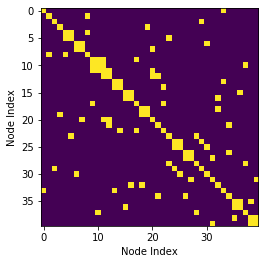

In [113]:
# add self loops to graph
for i in LG.nodes:
    LG.add_edge(i, i)

adj = nx.adjacency_matrix(LG).todense()
adj = np.array(adj).astype("d")
np.save(adj_path, adj)
if show_plots:
#     fig = plt.subplots(figsize=figsize, dpi=dpi)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")

    plt.imshow(adj)
    plt.show()

## Extraction of Rail Link Features

In [23]:
# # this shows that 99% of trains have a travel time of less than 30 minutes, so we should have a smaller time window
# # let's try 10 minutes
# a = max(df["travel_time_sched"])
# b = df.loc[df["travel_time_sched"] > 30]
# print(len(b))
# print(len(df))

In [30]:
## find starting and ending time for the day
dt = 10 # minutes

def round_time(t_input, dt, direction="floor"):
    # 
    if direction == "floor":
        n_minutes = ((pd.to_timedelta(str(t_input[0:2] + ":" + t_input[2:4] + ":00")).seconds / 60) // dt * dt)
        return pd.to_timedelta(n_minutes, unit="m")
    
    elif direction == "ceil":
        n_minutes = ((pd.to_timedelta(str(t_input[0:2] + ":" + t_input[2:4] + ":00")).seconds / 60 + dt) // dt * dt)
        return pd.to_timedelta(n_minutes, unit="m")
    
t_min = min(df["dep_sched_int"])
t_max = max(df["dep_sched_int"])
t_start = round_time(t_min, dt)
t_end = round_time(t_max, dt, "ceil")

# unique times during each day
time_list = []
t_curr = t_start

while t_curr < t_end:
    time_list.append(t_curr)
    t_curr += pd.Timedelta(str(dt) + "minutes")

# unique dates of the year
date_list = np.unique(df["date"])

datetime_list = []
for i in date_list:
    t0 = pd.to_datetime(i + " 00:00:00")
        
    for j in time_list:
        t_curr = t0 + j
        datetime_list.append(t_curr)

In [31]:
## construct useful mappings
# mapping from node description to unique index
LG_node_idx = {}
# mapping from unique index to node description 
LG_idx_node = {}
counter = 0
for i in LG.nodes():
    LG_node_idx[i] = counter
    LG_idx_node[counter] = i
    counter += 1


# mapping from node description to label (i.e. "SWAPAD")
LG_node_label = edge_label
# mapping from label to node description
LG_label_node = {}
for i in LG_node_label:
    LG_label_node[LG_node_label[i]] = i


# mapping from time of year to time data index
datetime_idx = {}
# mapping from time data index to time of year
idx_datetime = {}
counter = 0
for i in datetime_list:
    datetime_idx[i] = counter
    idx_datetime[counter] = i
    counter += 1

In [32]:
n_nodes = len(adj)
n_timesteps = len(datetime_list)
n_features = 1 #  delay per link
n_timesteps_per_day = ((t_end - t_start)/dt).seconds / 60
delay_dataset = np.zeros((n_timesteps, n_nodes, n_features))
n_trains_total = np.zeros((n_nodes, 1))
n_trains_link_dt = np.zeros((n_timesteps, n_nodes, 1))

for i in range(len(datetime_list)-1):
    # get set of trains running during current time period    
    t0, t1 = datetime_list[i], datetime_list[i+1]
    
    # attribute the link delay to all relevant times 
    ## i.e. from scheduled departure of previous station to scheduled arrival at current station
    t_avg_cond = ((t0 <= df["prev_link_avg_datetime"]) & (df["prev_link_avg_datetime"] <= t1))
    t_arr_cond = ((t0 <= df["arr_sched_datetime"]) & (df["arr_sched_datetime"] <= t1))
    t_dep_cond = ((t0 <= df["prev_station_dep_sched_datetime"]) & (df["prev_station_dep_sched_datetime"] <= t1))
    
    df_tmp = df.loc[t_avg_cond | t_dep_cond | t_arr_cond]
    n_trains_link = np.zeros((n_nodes, 1))

    for j in range(len(df_tmp)):
        curr_row = df_tmp[j:j+1]
        prev_links = curr_row["prev_links"].item()

        for k in range(len(prev_links)):
            link = prev_links[k]
            link_idx = LG_node_idx[LG_label_node[link]]

            # sum the average delay experienced by trains passing through link during the time period
            delay_dataset[i, link_idx, 0] += curr_row["prev_link_delay"].item()
            
            # enumerate trains passing through each link during the time period
            n_trains_link[link_idx] += 1
    n_trains_link_dt[i, :, :] = n_trains_link
    n_trains_total += n_trains_link
    
    # calculate delay over each link averaged by number of trains that passed through the link during the time period
    divisor = n_trains_link + np.where(n_trains_link == 0, 1, 0)
    delay_dataset[i, :, :] = delay_dataset[i, :, :] / divisor

np.save(dataset_path, delay_dataset)


In [33]:
print("n_timesteps_per_day:", n_timesteps_per_day)
print("n_nodes", n_nodes)


n_timesteps_per_day: 42.0
n_nodes 40


# Making Plots for ITSC Paper

## Number of traversals per link during 2016 and 2017


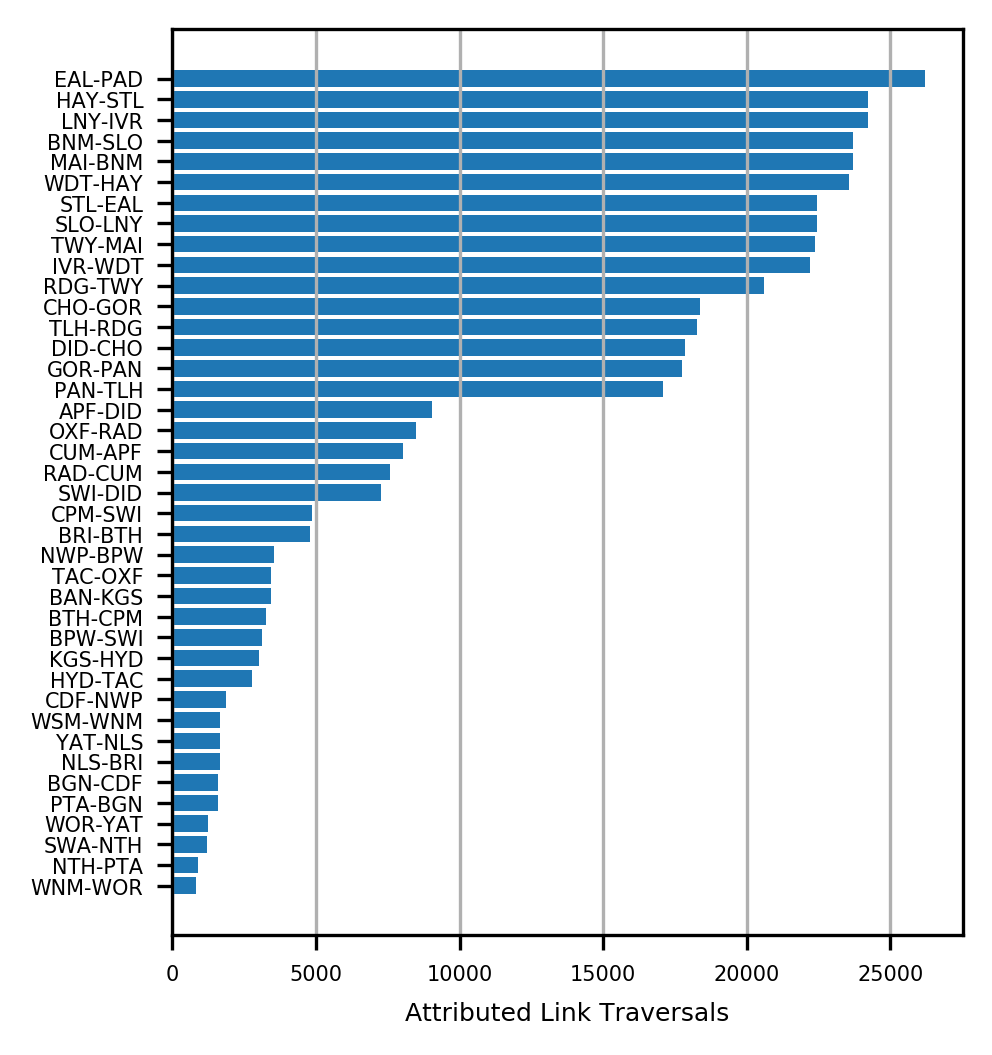

In [930]:
label_traversals = {}
idx_traversals = {}

for i in range(len(n_trains_total)):
    label_traversals[LG_node_label[LG_idx_node[i]]] = int(n_trains_total[i].item())
    idx_traversals[i] = int(n_trains_total[i].item())
    
idx_traversals = {k: v for k, v in sorted(idx_traversals.items(), key=lambda item: item[1], reverse=True)}

label_traversals = {k: v for k, v in sorted(label_traversals.items(), key=lambda item: item[1], reverse=True)}
labels, y = zip(*label_traversals.items())
labels = list(labels)
for i in range(len(labels)):
    labels[i] = labels[i][0:3] + "-" + labels[i][3:]
    
x = np.arange(0, len(y))
x = sorted(x, reverse=True)
y = sorted(y, reverse=True)

fig, ax = plt.subplots(figsize=(3.4, 4), dpi=dpi)
plt.barh(x,y)
# plt.ylabel("Link Name")
plt.xlabel("Attributed Link Traversals", fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.set(yticks=x, yticklabels=labels)
plt.grid(axis="x")
# plt.title("Link Traversals for 2016 and 2017")
plt.show()

## Plotting actual delay vs predicted delay

In [259]:
# first find a really busy time of the day
total_trains_per_link = np.sum(n_trains_link_dt, axis=1)
# 68 links were traversed on the entire network during this 10 minute period

busy_idx = np.argmax(total_trains_per_link)
curr_date = datetime_list[busy_idx]
date_str = str(curr_date.year) + "-0" + str(curr_date.month) + "-" + str(curr_date.day)

df_plot = df.loc[df["date"] == date_str]

# get time at which we will collect data
datetime_plot = []
t0 = pd.to_datetime(date_str + " 00:00:00")
for j in time_list:
    t_curr = t0 + j
    datetime_plot.append(t_curr)
    
# get date indicies of delay_dataset for visualization of model 
idx_plot = []
for i in datetime_plot:
    if i in datetime_list:
        idx_plot.append(datetime_list.index(i))

datetime_plot_str = []
for i in datetime_plot:
    datetime_plot_str.append(str(i)[11:])

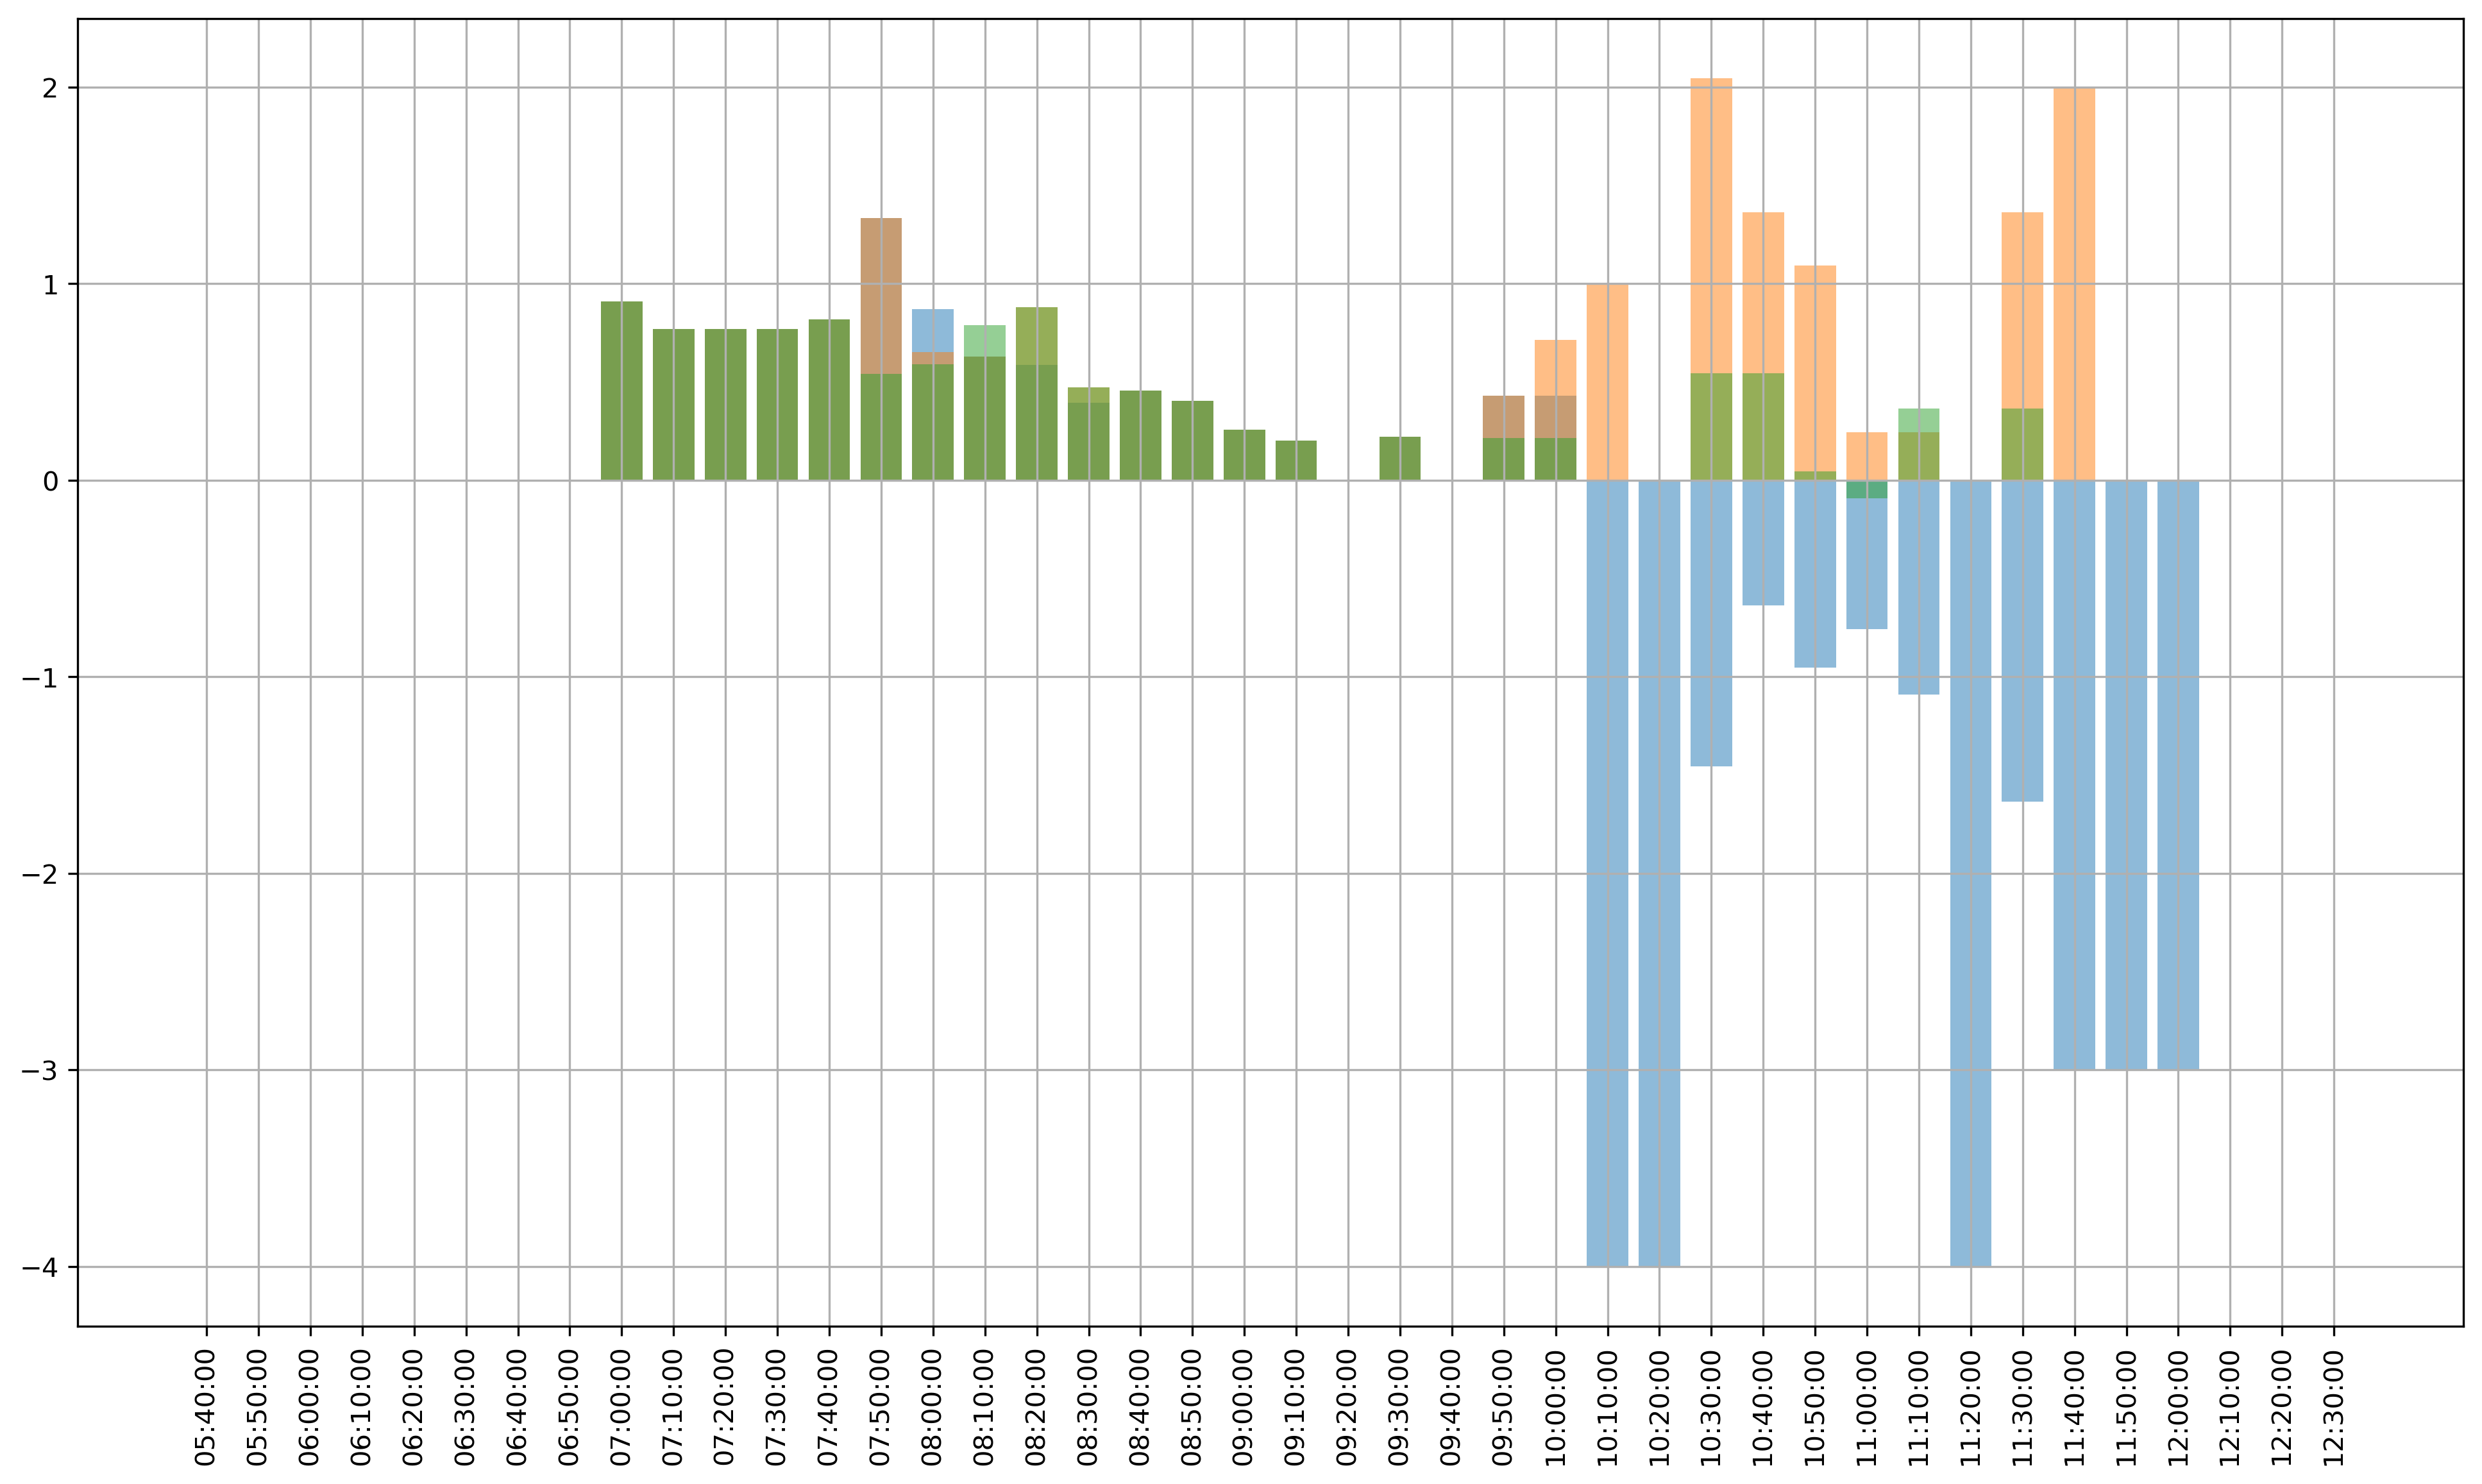

In [293]:
data_plot = delay_dataset[idx_plot, :, :]
fig, ax = plt.subplots(figsize=(16, 9), dpi=dpi)
#TODO this is probably better-visualized as a bar graph
## the times are valid for the entire 10-minute period, but this shows the delays as changing during the periods

# plot the delay state for the n_plot busiest links during an average day

x_ticks = np.arange(0, data_plot.shape[0])
n_plot = 3
counter = 0
for i in list(idx_traversals):
    if counter < n_plot:
        plt.bar(x_ticks,data_plot[:, i].squeeze(), alpha=0.5)
        plt.xticks(x_ticks)
        ax.set_xticklabels(datetime_plot_str, rotation=90)
        counter += 1

plt.grid()
plt.show()

## Model Accuracy Results

In [308]:
fp = "./paper_data/experiment_results.csv"
df_acc = pd.read_csv(fp)

In [310]:
model_names = np.unique(df_acc["Model"])
timesteps_in = np.unique(df_acc["Timesteps In"])

for i in model_names:
    print("\n\n", i)
    df_tmp1 = df_acc.loc[df_acc["Model"] == i]
    for j in timesteps_in:
        print("Timesteps In", j)
        df_tmp2 = df_tmp1.loc[df_tmp1["Timesteps In"] == j]

        print("MAE")
        mae_str = ""
        for k in range(len(df_tmp2)):
            curr_row = df_tmp2[k: k+1]
            mae_str += str(round(curr_row["MAE (test)"].item(), 3))
            mae_str += " / "
        print(mae_str)
        
        print("RMSE")
        rmse_str = ""
        for k in range(len(df_tmp2)):
            curr_row = df_tmp2[k: k+1]
            rmse_str += str(round(curr_row["RMSE (test)"].item(), 3))
            rmse_str += " / "
        print(rmse_str)



 Linear Regression
Timesteps In 4
MAE
0.305 / 
RMSE
0.7 / 
Timesteps In 6
MAE
0.304 / 0.365 / 0.36 / 
RMSE
0.69 / 0.782 / 0.847 / 
Timesteps In 12
MAE
0.279 / 0.337 / 0.338 / 
RMSE
0.59 / 0.753 / 0.785 / 


 Multi-Layer Perceptron
Timesteps In 4
MAE
0.343 / 
RMSE
0.973 / 
Timesteps In 6
MAE
0.341 / 0.362 / 0.364 / 
RMSE
0.966 / 0.915 / 1.096 / 
Timesteps In 12
MAE
0.331 / 0.34 / 0.327 / 
RMSE
0.982 / 0.896 / 0.931 / 


 STGCN
Timesteps In 4
MAE
0.259 / 
RMSE
0.62 / 
Timesteps In 6
MAE
0.256 / 0.311 / 0.302 / 
RMSE
0.625 / 0.803 / 0.755 / 
Timesteps In 12
MAE
0.25 / 0.282 / 0.27 / 
RMSE
0.539 / 0.713 / 0.669 / 


## Better Plot of Graph and Line Graph

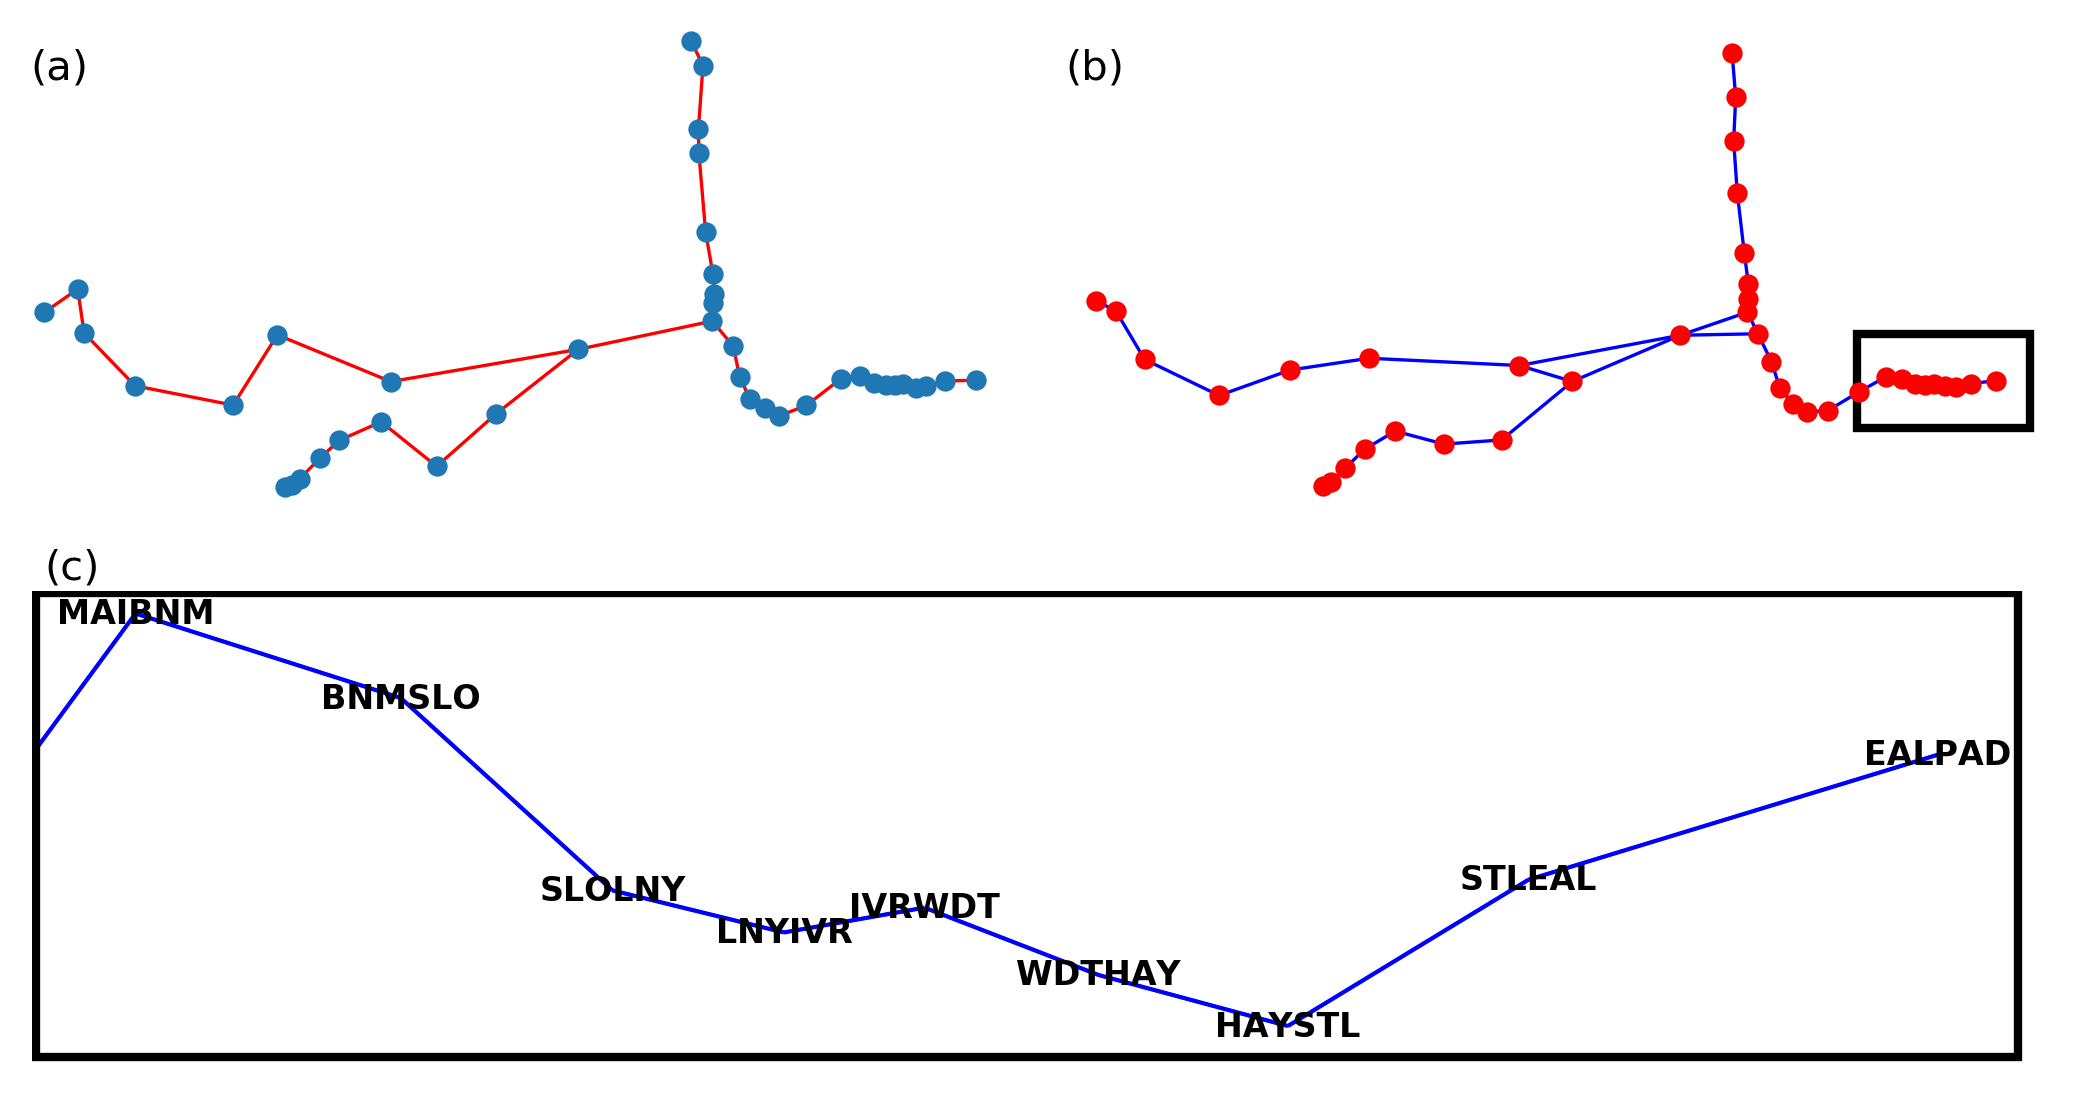

In [940]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
# fig, ax = plt.subplots(nrows=1 ,ncols=3,figsize=(7.5, 2.5), dpi=dpi)

xlim = (-3.99, 0)
ylim = (51.32, 52.08)

fig = plt.figure(tight_layout=True, figsize=(7.05, 3.75), dpi=dpi)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
nx.draw(G, idx_position, node_size=15, width=0.8, color="b", edge_color="r")
plt.xlim(xlim)
plt.ylim(ylim)
plt.text(-4,52, "(a)")
plt.tight_layout()


ax = fig.add_subplot(gs[0, 1])
nx.draw(LG, edge_position, node_size=15, width=0.8, node_color="r", edge_color="b")
# draw rectangle for the zoomed image
rect = Rectangle((-0.8,51.44),0.7,0.15,linewidth=2,edgecolor='k',facecolor='None')
ax.add_patch(rect)
plt.text(-4,52, "(b)")
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()

ax = fig.add_subplot(gs[1, :])
plt.sca(ax)
nx.draw(LG, edge_position, node_size=0, width=0.8, node_color="r", edge_color="b")
nx.draw_networkx_labels(LG, edge_position, edge_label, font_size=8, font_weight="bold")
nx.draw_networkx_edges(LG, edge_position, edge_color="b")

# these work for zooming in around London
xlim = (-0.71, -0.21)
ylim = (51.503, 51.522)
rect = Rectangle((-0.7091,51.5033),0.49,0.0186,linewidth=2,edgecolor='k',facecolor='None')
ax.add_patch(rect)
plt.text(-0.707,51.5033 + 0.0192, "(c)")

# drawing line works, but it squishes the image vertically which isn't ideal for a paper
# # draw lines pointing from the small rectangle to the large rectangle
# # vertical line
# # bottom point
# x1, y1 = (-0.707+0.47, 51.503 + 0.0187), (-0.707+0.47, 51.503+0.0187)
# # top point
# x2, y2 = (-0.707+0.49, 51.503 + 0.037), (-0.707+0.49, 51.503+0.037)

# # slanted line
# #bottom point
# x3, y3 = (-0.707+0.4, 51.503 + 0.0187), (-0.707+0.4, 51.503+0.0187)
# # top point
# x4, y4 = (-0.707+0.45, 51.503+0.037), (-0.707+0.45, 51.503+0.037)


# lines = [[x1, y1, x2, y2], [x3, y3, x4, y4]]
# # lines = [[x1, y1, x2, y2]]
# lc = mc.LineCollection(lines, linewidths = 1, color="k", zorder=0)
# lc.set_clip_on(False)
# ax.add_collection(lc)

plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()

plt.show()

## Training Curve

In [238]:
in_list = [6, 12]
out_list= [1, 3, 6]

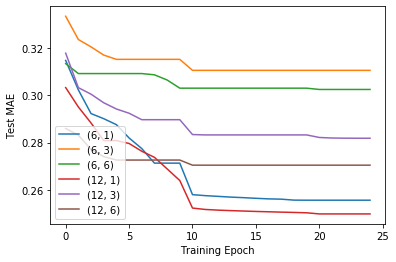

In [243]:
for i in in_list:
    for j in out_list:
        fp = "./paper_data/training_curves/in_{}_out_{}_run-.-tag-Mean Absolute Error (testing).csv".format(i, j)
        df_train = pd.read_csv(fp)
        plt.plot(df_train["Step"], df_train["Value"], label=(i, j))
        plt.xlabel("Training Epoch")
        plt.ylabel("Test MAE")

plt.legend()
plt.show()

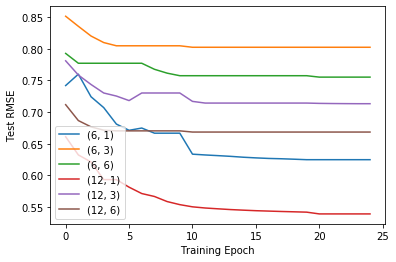

In [245]:
for i in in_list:
    for j in out_list:
        fp = "./paper_data/training_curves/in_{}_out_{}_run-.-tag-Root Mean Squared Error (testing).csv".format(i, j)
        df_train = pd.read_csv(fp)
        plt.plot(df_train["Step"], df_train["Value"], label=(i, j))
        plt.xlabel("Training Epoch")
        plt.ylabel("Test RMSE")
plt.legend()
plt.show()

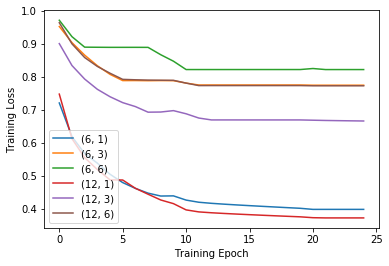

In [246]:
for i in in_list:
    for j in out_list:
        fp = "./paper_data/training_curves/in_{}_out_{}_run-.-tag-Average Training Loss.csv".format(i, j)
        df_train = pd.read_csv(fp)
        plt.plot(df_train["Step"], df_train["Value"], label=(i, j))
        plt.xlabel("Training Epoch")
        plt.ylabel("Training Loss")
plt.legend()
plt.show()